## Lab 11: Understanding regularization effect

In this lab, we will force logistic regression to overfit data and see the effect


### A few imports

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import Output,interact
from IPython.display import display
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib.widgets import Slider, Button, TextBox
import matplotlib.colors as colors
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

### Help functions

In [2]:
def sigmoid_grid(t,coef_meshgrid):

    data = np.ones((t.shape[0],2))
    data[:,0] = t[:,0] # Ndata * 2
    result = - np.inner(coef_meshgrid,data) # size_mesh,ndata
    return 1/(1+np.exp(result))

In [3]:
def log_likelihood_grid(t,litho,coef_meshgrid):
    prob_litho1 = sigmoid_grid(t,coef_meshgrid)
    sum_prob = np.inner(np.log10(prob_litho1),litho) + np.inner(np.log10(1-prob_litho1),1-litho) # size_mesh,
    n = litho.shape[0]
    return -sum_prob/(n)


In [4]:
def der_log_likelihood(t,litho,coef):
    data = np.ones((t.shape[0],2))
    data[:,0] = t[:,0] # Ndata * 2
    term = np.inner(sigmoid_grid(t,coef)-litho,data.T) # dim 1*2
    n = t.shape[0]
    return term / n

In [5]:
def update_parameters(t,litho,coef,learning_rate):
    coef = coef - learning_rate * der_log_likelihood(t,litho,coef)
    return coef

### Fetching data

In [ ]:
# Fetch data

datapath = 'https://raw.githubusercontent.com/scienxlab/datasets/refs/heads/main/rpc/rpc-4-lithologies.csv' # Put your own path here
df = pd.read_csv(datapath)

In [7]:
# The data consist in samples from the rock property catalogs, compiled in https://agilescientific.com/blog/2015/10/5/the-rock-property-catalog-again, 
# compiled about Cretaceous shales in North America. In this subset, we have 4 different types of rocks and 3 parameters 
# (Rho = bulk density; vp = P-wave velocity and vs = S-wave velocity)

df.Lithology.unique()

array(['sandstone', 'shale', 'limestone', 'dolomite'], dtype=object)

In [8]:
df.columns

Index(['RPC', 'Description', 'Lithology', 'Vp', 'Vs', 'Rho'], dtype='object')

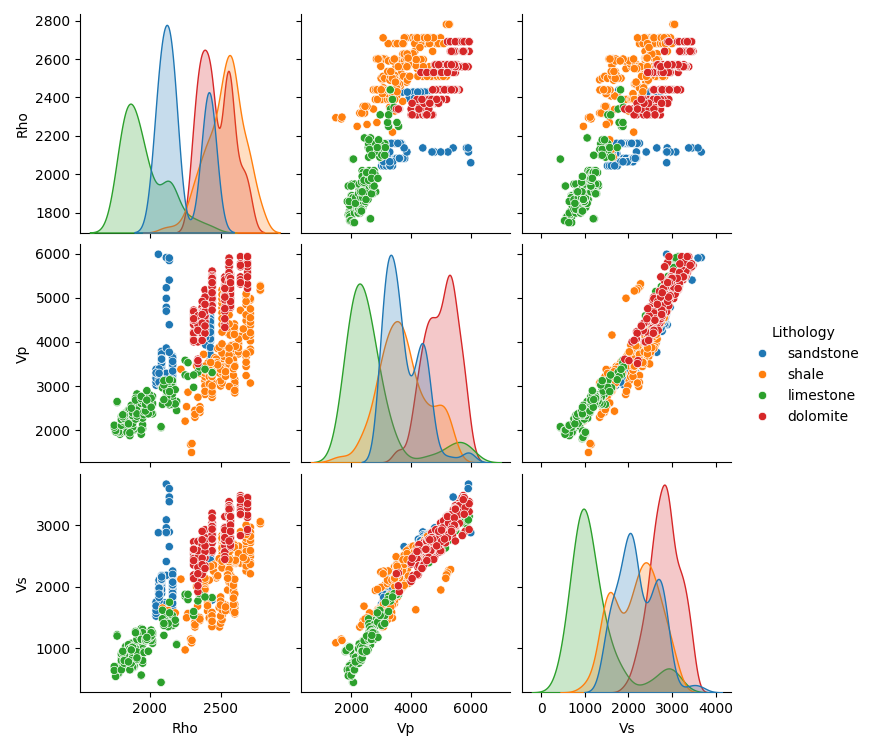

In [9]:
# Making a few plots to get to know the data:
# It looks like we could well discriminate data using a combination of 2 attributes. We'll start before that with one attribute

sns.pairplot(df,hue='Lithology',vars=['Rho','Vp','Vs'])

### OVerfitting the Logstic regression

We select two lithologies and two attributes where the logistic regression has problems for instance:

In [28]:
### SELECT one attribute to work with and 2 lithologies

att_sel = ['Vp','Vs']
litho_0 = 'limestone' 
litho_1 = 'shale'

In [29]:
### Extract data relevant for analysis 

work_df = df[att_sel + ['Lithology']].copy()
work_df = work_df.query('Lithology ==@litho_0 | Lithology ==@litho_1')

# Then we encode the lithology to 0/1
#work_df['Lithology']=work_df.Lithology.replace({litho_0:0,litho_1:1})
#work_df['Vp']=work_df['Vp'].apply(lambda x:x/4000)
#work_df['Vs']=work_df['Vs'].apply(lambda x:x/2000)
work_df.dropna(axis=0,how='any',inplace=True)

In [30]:
# So now here is our working data wiht a few stats

work_df.groupby('Lithology').describe()

Vp                                                     \
           count         mean          std          min         25%   
Lithology                                                             
limestone  200.0  2714.519650  1020.160926  1803.350000  2074.72250   
shale      200.0  3735.142429   806.545652  1490.711927  3206.45926   

                                                 Vs                           \
                   50%          75%      max  count         mean         std   
Lithology                                                                      
limestone  2384.190000  2803.972500  5940.00  200.0  1245.173350  628.649198   
shale      3669.257924  4267.198324  5320.42  200.0  2161.900601  507.827205   

                                                                   
              min          25%          50%          75%      max  
Lithology                                                          
limestone  441.27   882.550000  1013.140000  1377.620000  3227.69  
shale      969.00  1666.941941  2242.597461  2563.782811  3058.00

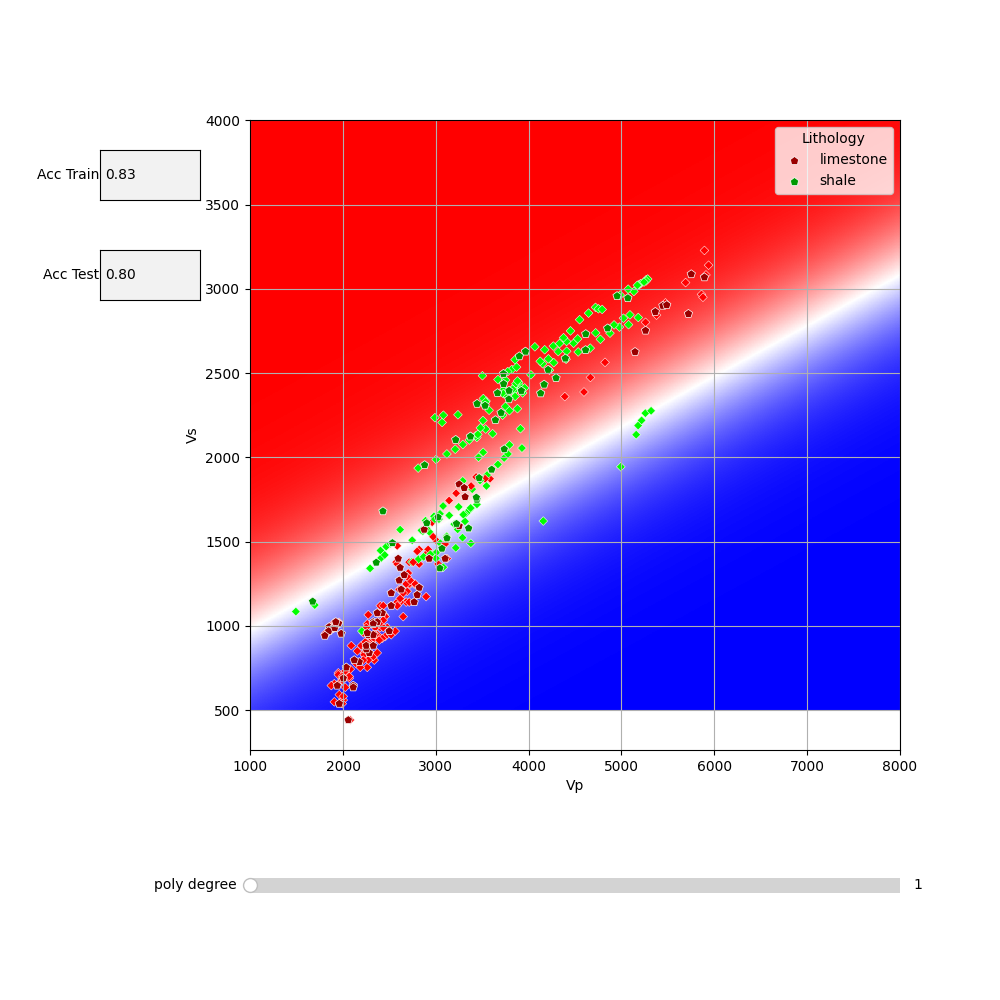

In [31]:
# The parametrized function to be plotted


xmin = 1000
xmax = 8000
ymin = 500
ymax = 4000

# Define calculation grid
x = np.linspace(xmin, xmax, 1000)
y = np.linspace(ymin, ymax, 1000)
XY = np.meshgrid(x,y)
xy =np.vstack((XY[0].flatten(),XY[1].flatten())).T

# Polynomial expansion degree
def grid_polynomial(data,litho,image_out,degree):
    xtrain,xtest,ytrain,ytest=train_test_split(data,litho)
    poly = PolynomialFeatures(degree=degree)
    normalize = StandardScaler()
    model = LogisticRegression()
    pipe = make_pipeline(poly,normalize,model)
    pipe.fit(xtrain,ytrain)
    prob_cl = pipe.predict_proba(image_out)
    score_train= pipe.score(xtrain,ytrain)
    score_test= pipe.score(xtest,ytest)

    return xtrain,xtest,ytrain,ytest,score_train,score_test,prob_cl
    
# Define cost function paysage
data_train,data_test,ytrain,ytest,score_train,score_test,prob_cl = grid_polynomial(work_df[att_sel],work_df.Lithology,xy,1)
data_train_all = pd.concat([data_train,ytrain],axis=1)
data_test_all = pd.concat([data_test,ytest],axis=1)

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('Vp')
ax.set_ylabel('Vs')
image=ax.pcolormesh(x,y,prob_cl[:,1].reshape(1000,1000),cmap='bwr',vmin=0,vmax=1)
mycmap={litho_0:[1,0,0],litho_1:[0,1,0]}
mycmap2={litho_0:[0.6,0,0],litho_1:[0,0.6,0]}
sns.scatterplot(data=data_train_all,x='Vp',y='Vs',hue='Lithology',s=20,marker='D',ax=ax,legend=False,palette=mycmap)
sns.scatterplot(data=data_test_all,x='Vp',y='Vs',hue='Lithology',s=40,marker='p',ax=ax,palette=mycmap2)
ax.grid()

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control degree
axlr = fig.add_axes([0.25, 0.1, 0.65, 0.03])
slider_values = np.arange(1,51)
slider_deg = Slider(
    ax=axlr,
    label='poly degree',
    valmin=slider_values[0], 
    valmax=slider_values[-1], 
    valinit=1,
    valstep=slider_values
)

axres = fig.add_axes([0.1, 0.8, 0.1, 0.05])
res_text = TextBox(
    ax=axres,
    label="Acc Train",
    initial='{:.2f}'.format(score_train)
)

axrestest = fig.add_axes([0.1, 0.7, 0.1, 0.05])
restest_text = TextBox(
    ax=axrestest,
    label="Acc Test",
    initial='{:.2f}'.format(score_test)
)

def update_slider(val):
    global work_df, att_sel
    data_train,data_test,ytrain,ytest,score_train,score_test,prob_cl = grid_polynomial(work_df[att_sel],
                                                                                       work_df.Lithology,
                                                                                       xy,
                                                                                       slider_deg.val)
    image.set_array(prob_cl[:,1].reshape(1000,1000))
    res_text.set_val('{:.2f}'.format(score_train))
    restest_text.set_val('{:.2f}'.format(score_test))

    fig.canvas.draw_idle()

slider_deg.on_changed(update_slider)




plt.show()

# Congratulations ! 
you understand now the conceåt of overfitting. 